## Here lets try to get some data from the alfven modes and train a few autoencoders on them to see if they capture any structure in the latent layer

In [1]:
using AlfvenDetectors
using PyPlot
using Flux
using CuArrays  # for GPU runs
using ValueHistories
using BSON: @save, @load

What we are doing is unsupervised training on columns of the magnitude squared coherence time histograms. 

### Collect the data

Use shot #10370 and #11960 and several coil couples. Select only some timeslices, normalize data

In [2]:
host = gethostname()
if occursin("vit", host)
    datapath = "/home/vit/vyzkum/alfven/cdb_data/original_data/"
else
    datapath = "/home/skvara/work/alfven/cdb_data/original_data/"
end

"/home/vit/vyzkum/alfven/cdb_data/original_data/"

In [3]:
function get_msc_array(datapath, shot, coil, timelim = [1.0, 1.25])
    _data = AlfvenDetectors.BaseAlfvenData(joinpath(datapath,"$(shot).h5"), [coil])
    tinds = timelim[1] .<= _data.t .<= timelim[2]
    return _data.msc[coil][:,tinds], _data.t[tinds], _data.f 
end

get_msc_array (generic function with 2 methods)

In [4]:
msc, t, f = get_msc_array(datapath, 11096, 18)

(Float32[0.953081 0.988718 … 0.969359 0.991565; 0.960025 0.987471 … 0.969421 0.989726; … ; 0.135501 0.00779018 … 0.0905129 0.0741393; 0.00198782 0.00124353 … 0.132843 0.0319265], Float32[1.00244, 1.00525, 1.00806, 1.01087, 1.01369, 1.0165, 1.01931, 1.02213, 1.02494, 1.02775  …  1.22462, 1.22744, 1.23025, 1.23306, 1.23588, 1.23869, 1.2415, 1.24431, 1.24713, 1.24994], Float32[0.0, 1953.13, 3906.25, 5859.38, 7812.5, 9765.63, 11718.8, 13671.9, 15625.0, 17578.1  …  9.82422e5, 984375.0, 9.86328e5, 9.88281e5, 9.90234e5, 9.92188e5, 9.94141e5, 9.96094e5, 9.98047e5, 1.0e6])

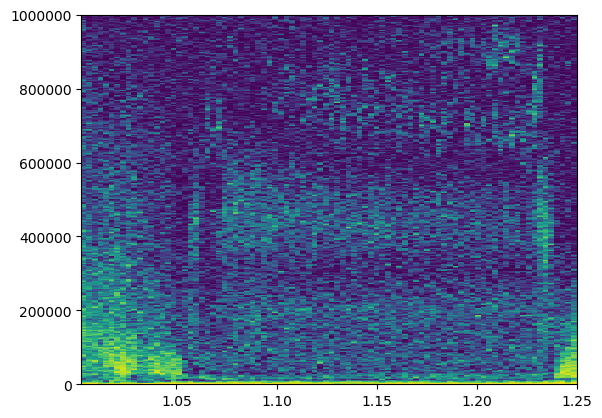

PyObject <matplotlib.collections.QuadMesh object at 0x7f5c76e797b8>

In [5]:
pcolormesh(t,f,msc)

In [6]:
function collect_msc(datapath, shot, coils)
    datalist = map(x-> get_msc_array(datapath, shot, x), coils)
    return hcat([x[1] for x in datalist]...), datalist[1][3]
end

collect_msc (generic function with 1 method)

In [7]:
shots_coils = [
#    [10370, [12, 15, 17, 20]],
    [10370, [12, 20]],
#    [11096, [11, 8, 17, 20]]
    [11096, [11, 8, 20]]
]
datalist = map(x->collect_msc(datapath, x[1], x[2]), shots_coils)
data, f = hcat([x[1] for x in datalist]...), datalist[1][2]

(Float32[0.918668 0.881605 … 0.908824 0.920963; 0.914609 0.879044 … 0.875875 0.849385; … ; 0.00910574 0.328996 … 0.0584963 0.0771319; 0.0011798 0.310406 … 0.192278 0.0363167], Float32[0.0, 1953.13, 3906.25, 5859.38, 7812.5, 9765.63, 11718.8, 13671.9, 15625.0, 17578.1  …  9.82422e5, 984375.0, 9.86328e5, 9.88281e5, 9.90234e5, 9.92188e5, 9.94141e5, 9.96094e5, 9.98047e5, 1.0e6])

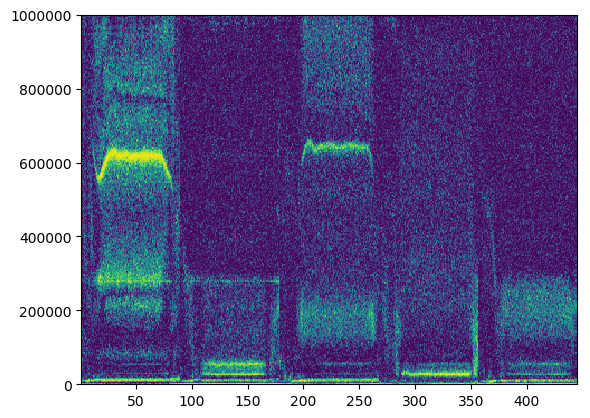

PyObject <matplotlib.collections.QuadMesh object at 0x7f5c4c0f7160>

In [8]:
pcolormesh(1:size(data,2), f, data)

### Now that we have the data, construct a (V)AE

Larger dimension of middle layer is beneficial, but improvement from 10 to 20 is much alrger than from 20 to 200.

Reconstruction works even with zdim = 2 although there are some artifacts.

In [9]:
M,N = size(data)
# fortunately data is already normalized in the interval (0,1)
zdim = 2
small_model = AlfvenDetectors.AE([M, 20, zdim], [zdim, 20, M])
large_model = AlfvenDetectors.AE([M, 200, zdim], [zdim, 200, M])
small_train_history = MVHistory()
large_train_history = MVHistory()
batchsize = 64
nepochs = 1000
cbit = 1
# progress bars are broken in notebooks
if occursin(".jl", @__FILE__) 
    verb = true
else
    verb = false
end

false

In [20]:
@info "Training small CPU model"
@time AlfvenDetectors.fit!(small_model, data, batchsize, nepochs;
    cbit = cbit, history = small_train_history, verb = verb)

┌ Info: Training small CPU model
└ @ Main In[20]:1


  3.502549 seconds (2.01 M allocations: 3.212 GiB, 27.20% gc time)


In [43]:
@info "Training large CPU model"
@time AlfvenDetectors.fit!(large_model, data, batchsize, nepochs;
    cbit = cbit, history = large_train_history, verb = verb)

┌ Info: Training large CPU model
└ @ Main In[43]:1


 10.624147 seconds (2.03 M allocations: 6.954 GiB, 13.78% gc time)


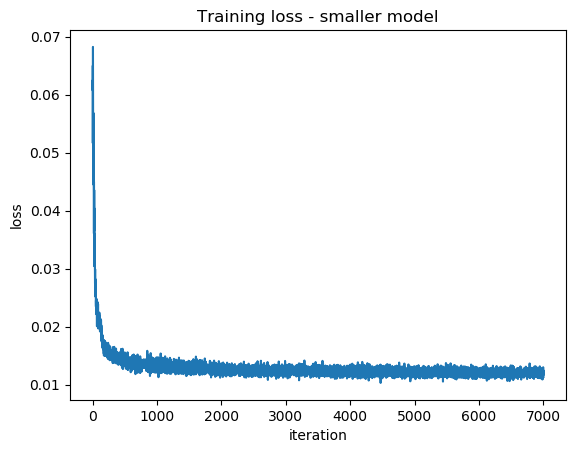

PyObject Text(24.000000000000007, 0.5, 'loss')

In [12]:
figure()
plot(get(small_train_history, :loss)...)
title("Training loss - smaller model")
xlabel("iteration")
ylabel("loss")

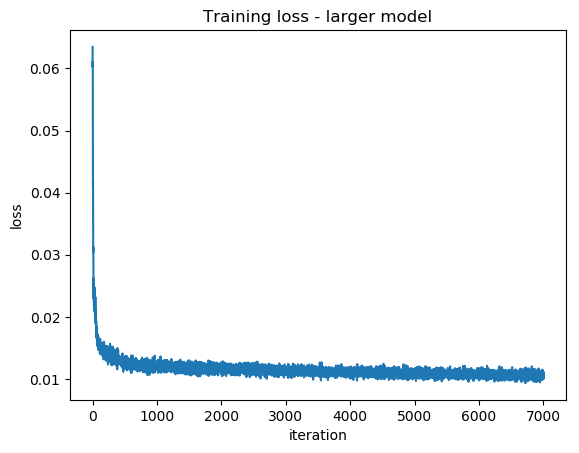

PyObject Text(24.000000000000007, 0.5, 'loss')

In [13]:
figure()
plot(get(large_train_history, :loss)...)
title("Training loss - larger model")
xlabel("iteration")
ylabel("loss")

In [14]:
X = data;

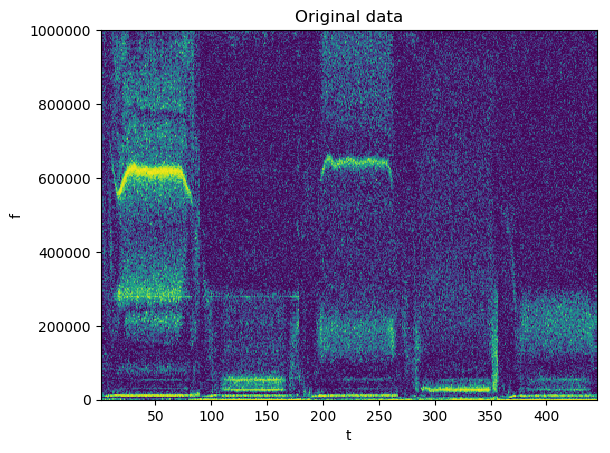

PyObject Text(24.0, 0.5, 'f')

In [15]:
figure()
pcolormesh(1:size(X,2), f, X)
title("Original data")
xlabel("t")
ylabel("f")

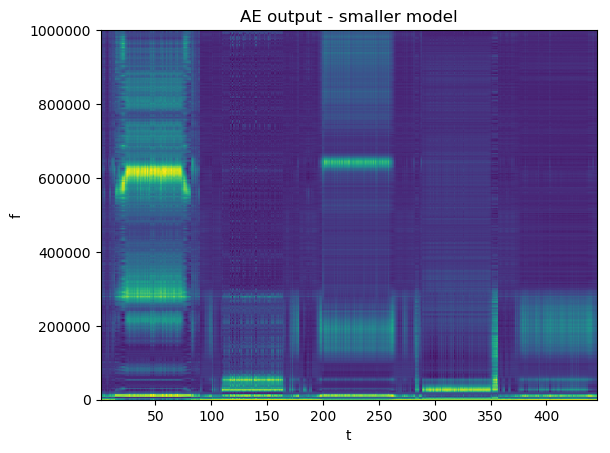

PyObject Text(24.0, 0.5, 'f')

In [16]:
figure()
sX = small_model(X).data
pcolormesh(1:size(sX,2), f, sX)
title("AE output - smaller model")
xlabel("t")
ylabel("f")

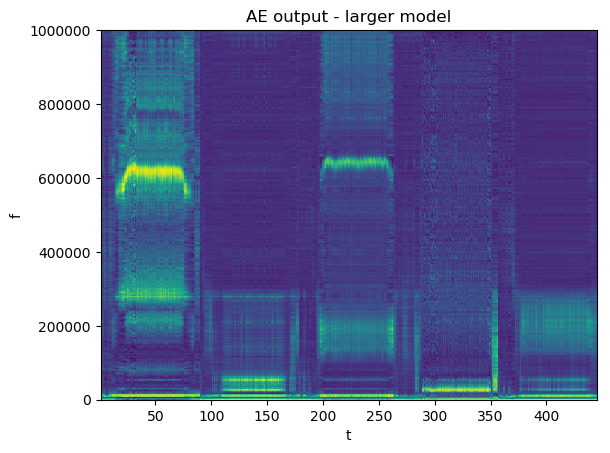

PyObject Text(24.0, 0.5, 'f')

In [17]:
figure()
lX = large_model(X).data
pcolormesh(1:size(lX,2), f, lX)
title("AE output - larger model")
xlabel("t")
ylabel("f")

## Basic training seems to work, now test the GPU version

In [41]:
# convert to CuArrays
zdim = 2
cudata = data |> gpu
cumodel = AlfvenDetectors.AE([M, 200, zdim], [zdim, 200, M]) |> gpu
cu_train_history = MVHistory()
nepochs = 200

200

In [42]:
@info "Training a large GPU model with less epochs in more iterations"
# clear cache
for i in 1:5
    @time AlfvenDetectors.fit!(cumodel, cudata, batchsize, nepochs;
        cbit = cbit, history = cu_train_history, verb = verb)
    # clear cache
    GC.gc()
end

┌ Info: Training a small GPU model
└ @ Main In[42]:1


  5.672054 seconds (8.07 M allocations: 284.300 MiB, 1.64% gc time)
  5.537571 seconds (7.98 M allocations: 281.182 MiB, 1.46% gc time)
  5.585410 seconds (7.98 M allocations: 281.280 MiB, 1.44% gc time)
  5.557051 seconds (7.98 M allocations: 281.166 MiB, 1.45% gc time)
  5.547477 seconds (7.98 M allocations: 281.194 MiB, 1.46% gc time)


In [64]:
@info "large CPU model(data) timing"
@time large_model(data);

  0.011865 seconds (110 allocations: 3.110 MiB)


┌ Info: large CPU model(data) timing
└ @ Main In[64]:1


In [65]:
@info "GPU model(data) timing"
@time cumodel(cudata);

  0.006157 seconds (392 allocations: 11.766 KiB)


┌ Info: GPU model(data) timing
└ @ Main In[65]:1


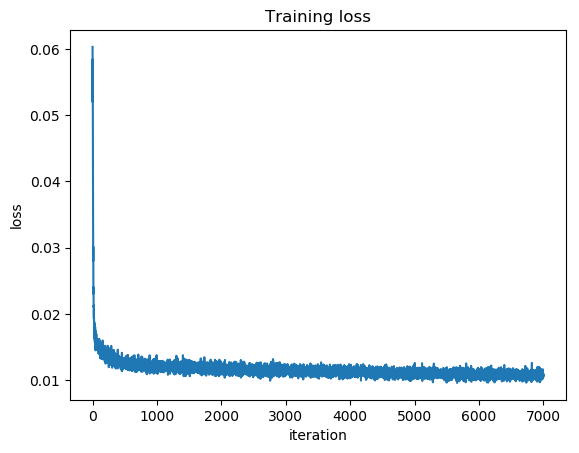

PyObject Text(24.000000000000007, 0.5, 'loss')

In [62]:
figure()
plot(get(cu_train_history, :loss)...)
title("Training loss")
xlabel("iteration")
ylabel("loss")

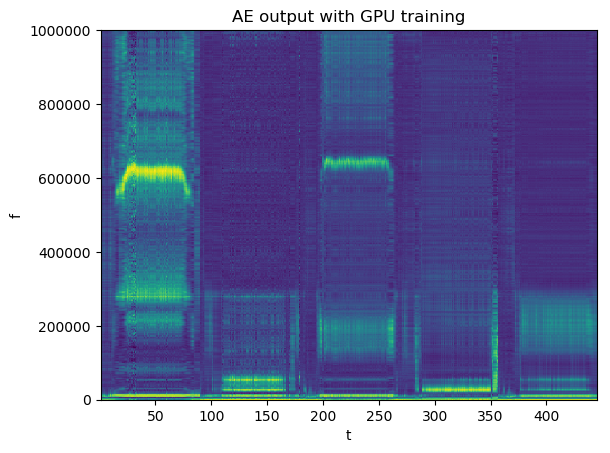

PyObject Text(24.0, 0.5, 'f')

In [63]:
figure()
X = cudata;
_X = cumodel(X).data |> cpu
pcolormesh(1:size(_X,2), f, _X)
title("AE output with GPU training")
xlabel("t")
ylabel("f")

Check further memory allocation for GPUs

## In this part, lets try to see some sort of structure in the latent code

In [ ]:
# save/load a pretrained model
f = "large_model.bson"
if !isfile(f) 
    @save f large_model
else
    @load f large_model
end

In [ ]:
X1, t1, f1 = get_msc_array(datapath, 11096, 11)
pcolormesh(t1, f1, X1)

In [ ]:
X0, t0, f0 = get_msc_array(datapath, 11096, 20)
pcolormesh(t0, f0, X0)

In [ ]:
Xα = X1[:,1.06.<=t1.<=1.22]
zα = large_model.encoder(Xα).data
z1 = large_model.encoder(X1).data
z0 = large_model.encoder(X0).data

In [ ]:
figure()
scatter(z1[1,:], z1[2,:], label = "positive")
scatter(z0[1,:], z0[2,:], label = "negative")
scatter(zα[1,:], zα[2,:], label = "alfven mode")
legend()

Now lets "generate" a new diagram.

In [ ]:
function connect(zs, l)
    L = length(zs)
    return vcat([hcat(
    collect(range(zs[i][1], zs[i+1][1]; length = l)), 
    collect(range(zs[i][2], zs[i+1][2]; length = l))
        )
    for i in 1:L-1]...)
end
zs = [[-6.5,-0.5], [-7.5,-2], [-7.5,-4], [-4,-4.5], [0,0]]
zpath = Array(connect(zs, 30)');

In [ ]:
figure()
scatter(z1[1,:], z1[2,:], label = "positive")
scatter(z0[1,:], z0[2,:], label = "negative")
scatter(zα[1,:], zα[2,:], label = "alfven mode")
plot(zpath[1,:], zpath[2,:], label = "artificial z")
legend()

In [ ]:
Xgen = large_model.decoder(zpath).data;

In [ ]:
figure()
pcolormesh(Xgen)
title("artificial coherence")

In [ ]:
show()